In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf, coint, adfuller
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels
import statsmodels.api as sm
register_matplotlib_converters()
from time import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
parser = (lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce'))

In [3]:
data = pd.read_csv('Data/MER_T12_06.csv', parse_dates=['YYYYMM'], index_col='YYYYMM', squeeze=True, date_parser=parser)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5094 entries, 1973-01-01 to 2016-07-01
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSN           5094 non-null   object
 1   Value         5094 non-null   object
 2   Column_Order  5094 non-null   int64 
 3   Description   5094 non-null   object
 4   Unit          5094 non-null   object
dtypes: int64(1), object(4)
memory usage: 238.8+ KB


In [5]:
ts = data[pd.Series(pd.to_datetime(data.index, errors='coerce')).notnull().values]

In [6]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4707 entries, 1973-01-01 to 2016-07-01
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSN           4707 non-null   object
 1   Value         4707 non-null   object
 2   Column_Order  4707 non-null   int64 
 3   Description   4707 non-null   object
 4   Unit          4707 non-null   object
dtypes: int64(1), object(4)
memory usage: 220.6+ KB


In [7]:
ts['Value'] = pd.to_numeric(ts['Value'], errors='coerce')
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4707 entries, 1973-01-01 to 2016-07-01
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSN           4707 non-null   object 
 1   Value         4323 non-null   float64
 2   Column_Order  4707 non-null   int64  
 3   Description   4707 non-null   object 
 4   Unit          4707 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 220.6+ KB


In [8]:
# 'Value' has some of N/A value => dropna
ts.dropna(inplace = True)

In [9]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4323 entries, 1973-01-01 to 2016-07-01
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSN           4323 non-null   object 
 1   Value         4323 non-null   float64
 2   Column_Order  4323 non-null   int64  
 3   Description   4323 non-null   object 
 4   Unit          4323 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 202.6+ KB


In [10]:
ts.head()

,MSN,Value,Column_Order,Description,Unit
YYYYMM,,,,,
1973-01-01,CLEIEUS,72.076,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-02-01,CLEIEUS,64.442,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-03-01,CLEIEUS,64.084,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-04-01,CLEIEUS,60.842,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-05-01,CLEIEUS,61.798,1,Coal Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide


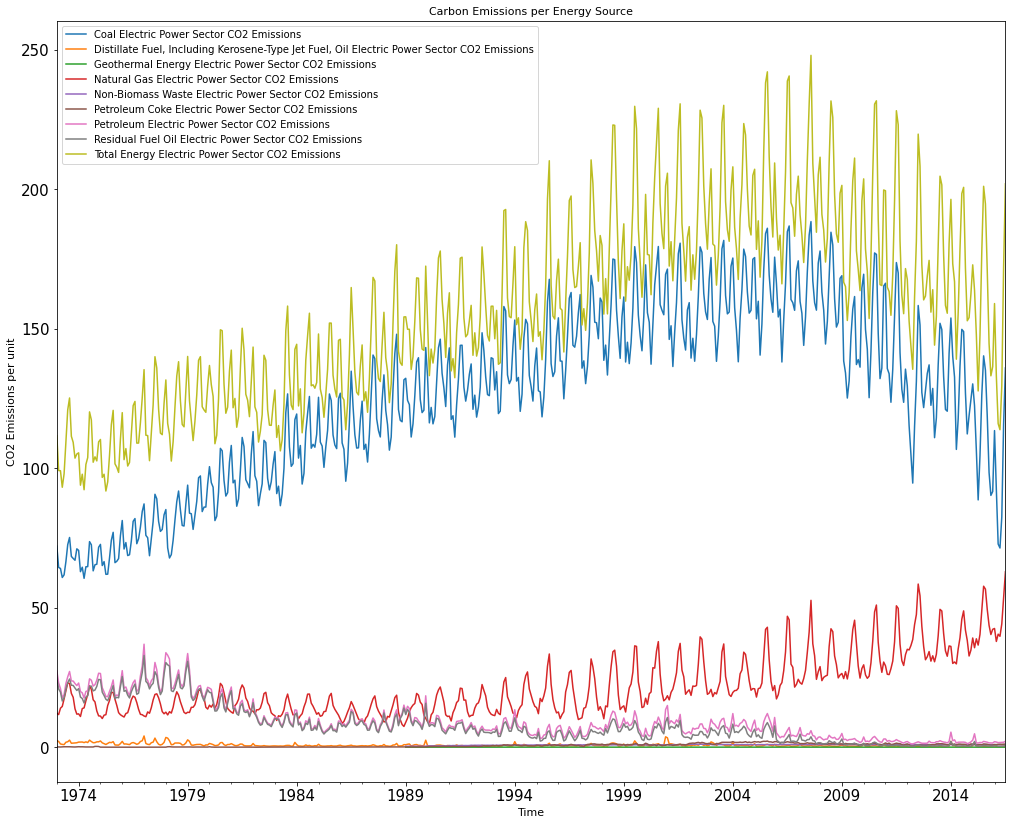

In [12]:
energy_sources = ts.groupby('Description')
rcParams['figure.figsize'] = 17, 14
fig, ax = plt.subplots()
for desc, group in energy_sources:
    group.plot(y = 'Value', label = desc,ax = ax, title ='Carbon Emissions per Energy Source' ,fontsize = 15)
    ax.set_xlabel('Time')
    ax.set_ylabel('CO2 Emissions per unit')
    ax.title.set_size(11)
    ax.xaxis.label.set_size(11)
    ax.yaxis.label.set_size(11)
    ax.legend(loc = 'best', fontsize = 10)

##### Comment
There is an increasing amount of CO2 emission from Natural Gas Electric Power from 1974 t0 2016 but also a decreasing in Coal, Petroleum, Distillate Fuel..

## Decompose the time series data

In [13]:
Emissions = ts.iloc[:,1:]
Emissions= Emissions.groupby(['Description', pd.Grouper(freq='M')])['Value'].sum().unstack(level = 0)
mte = Emissions['Natural Gas Electric Power Sector CO2 Emissions']
mte.head()

YYYYMM
1973-01-31    12.175
1973-02-28    11.708
1973-03-31    13.994
1973-04-30    14.627
1973-05-31    17.344
Freq: M, Name: Natural Gas Electric Power Sector CO2 Emissions, dtype: float64

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [15]:
decomposition = seasonal_decompose(mte, model='additive')

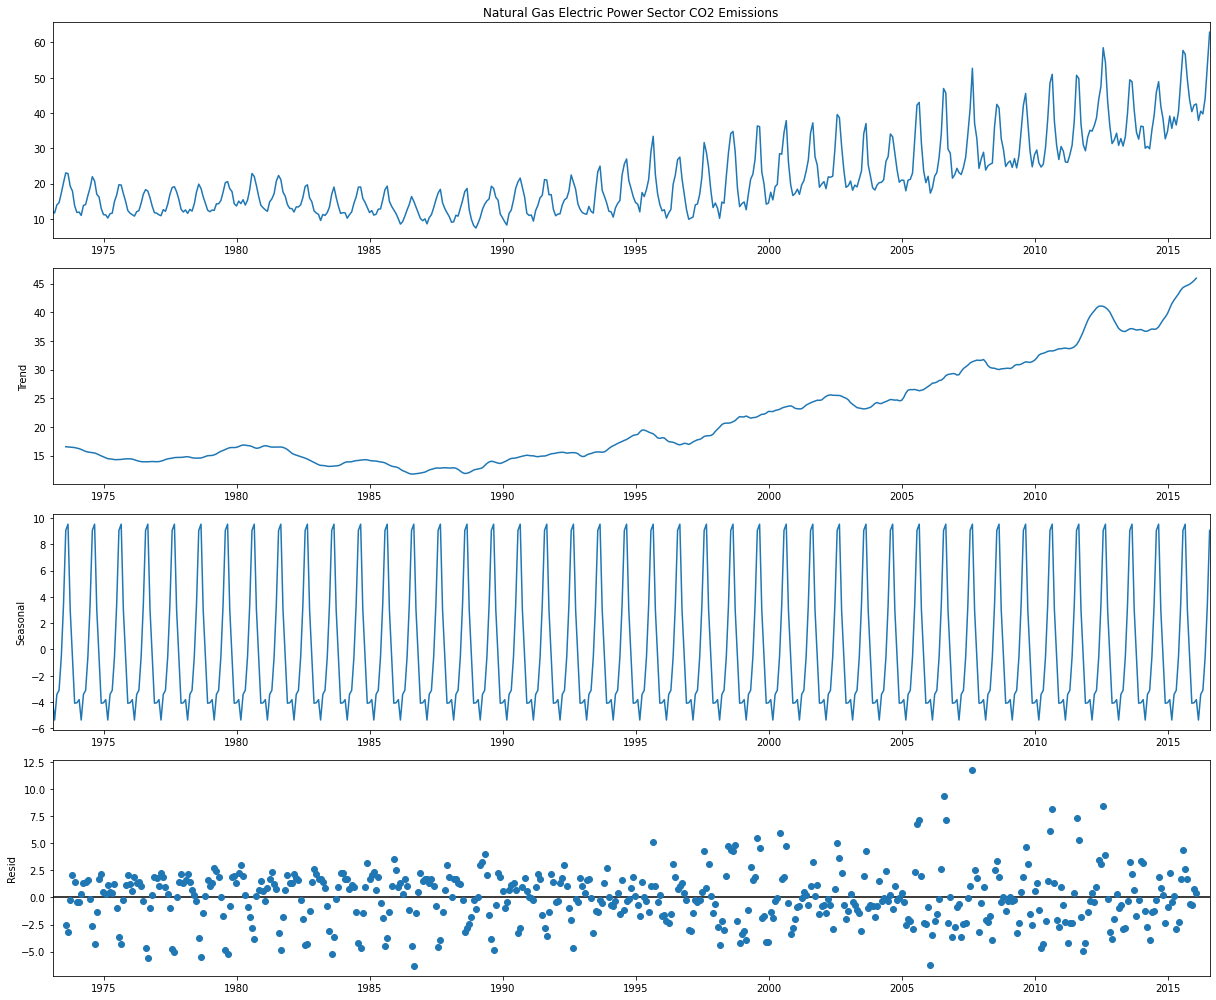

In [16]:
decomposition.plot()
plt.show()

##### Comment
The graph shows that the moving average fluctuates around 0, and the variance is also very small, which shows that the difference made the data similar to stationary.

## Use auto_arima to find the best model

In [17]:
from pmdarima import auto_arima

In [18]:
model = auto_arima(mte,
                   start_p=1,
                   start_q=1,
                   max_p=5,
                   max_q=5,
                   m=12,
                   start_P=1,
                   start_Q=1,
                   max_P=5,
                   max_Q=5,
                   d=1, D=1,
                   error_action='ignore',
                   trace=True,
                   suppress_warnings=True,
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2054.286, Time=1.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2332.657, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2181.357, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2090.016, Time=0.37 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2052.378, Time=0.76 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2246.348, Time=0.27 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2054.272, Time=2.55 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2140.515, Time=0.67 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=2056.153, Time=4.36 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2099.696, Time=0.33 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=2053.999, Time=1.42 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=2053.898, Time=1.41 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2115.132, Time=0.24 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2071.845, Time=0.48 sec
 ARIMA(2,1,0)(0,1,1

In [19]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  523
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1022.189
Date:                            Wed, 05 Oct 2022   AIC                           2052.378
Time:                                    10:02:26   BIC                           2069.316
Sample:                                01-31-1973   HQIC                          2059.019
                                     - 07-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6707      0.039     17.127      0.000       0.594       0.747
ma.L1         -0.9542      0.020   

In [20]:
# Split data into train and test
train = mte["1973-01-01":"2014-01-01"]
test = mte["2014-01-01":]

In [21]:
model.fit(train)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [22]:
forecast = model.predict(n_periods=len(test))

In [23]:
forecast_table = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

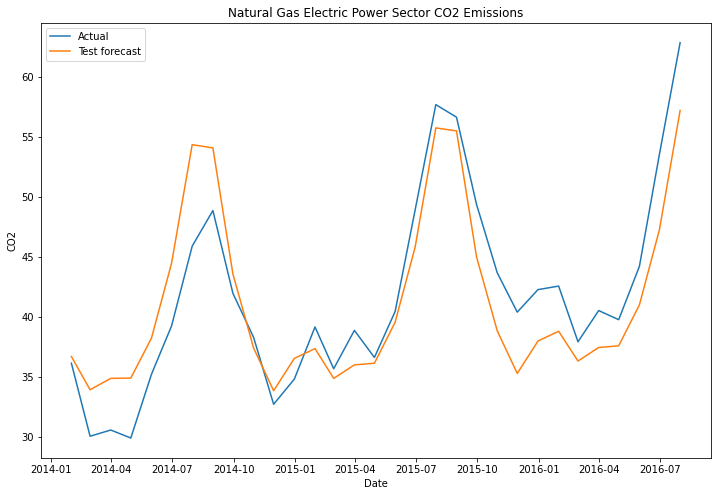

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(test.index, test, label='Actual')
plt.plot(forecast_table.index, forecast_table['Prediction'], label='Test forecast')
plt.title('Natural Gas Electric Power Sector CO2 Emissions')
plt.xlabel('Date')
plt.ylabel('CO2')
plt.legend()

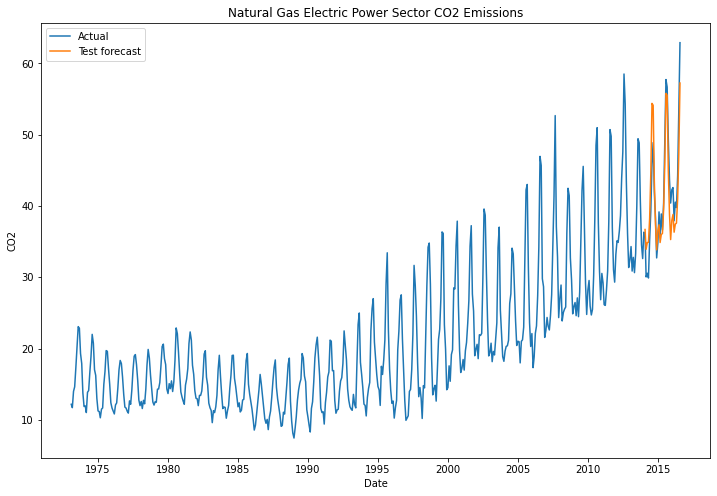

In [25]:
# Plot the forecast
plt.figure(figsize=(12, 8))
plt.plot(mte.index, mte, label='Actual')
plt.plot(forecast_table.index, forecast_table['Prediction'], label='Test forecast')
plt.title('Natural Gas Electric Power Sector CO2 Emissions')
plt.xlabel('Date')
plt.ylabel('CO2')
plt.legend()

## Predict the next 36 months

In [26]:
model.fit(mte)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [27]:
forecast = model.predict(n_periods=36)

In [28]:
predict_index = pd.date_range(start=test.index[-1], periods=36, freq='M')

In [29]:
forecast_table_36 = pd.DataFrame(forecast, index=predict_index, columns=['Prediction'])

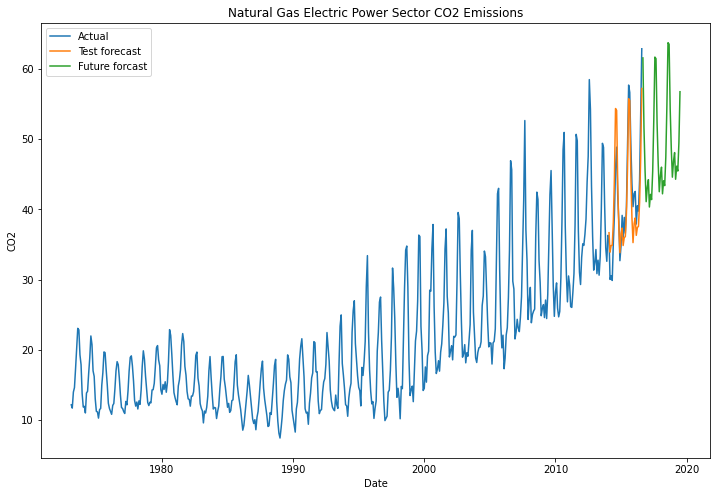

In [30]:
# Plot the forecast
plt.figure(figsize=(12, 8))
plt.plot(mte.index, mte, label='Actual')
plt.plot(forecast_table.index, forecast_table['Prediction'], label='Test forecast')
plt.plot(forecast_table_36.index, forecast_table_36['Prediction'], label='Future forcast')
plt.title('Natural Gas Electric Power Sector CO2 Emissions')
plt.xlabel('Date')
plt.ylabel('CO2')
plt.legend()

##### Conclusion
The forecast shows that the CO2 emission from natural gas power generation is expected to continue increasing.